# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [3]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

pd.set_option('display.max_columns', None)

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Описание данных**

airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

balcony — число балконов

ceiling_height — высота потолков (м)

cityCenters_nearest — расстояние до центра города (м)

days_exposition — сколько дней было размещено объявление (от публикации до снятия)

first_day_exposition — дата публикации

floor — этаж

floors_total — всего этажей в доме

is_apartment — апартаменты (булев тип)

kitchen_area — площадь кухни в квадратных метрах (м²)

last_price — цена на момент снятия с публикации

living_area — жилая площадь в квадратных метрах (м²)

locality_name — название населённого пункта

open_plan — свободная планировка (булев тип)

parks_around3000 — число парков в радиусе 3 км

parks_nearest — расстояние до ближайшего парка (м)

ponds_around3000 — число водоёмов в радиусе 3 км

ponds_nearest — расстояние до ближайшего водоёма (м)

rooms — число комнат

studio — квартира-студия (булев тип)

total_area — общая площадь квартиры в квадратных метрах (м²)

total_images — число фотографий квартиры в объявлении

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [8]:
data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

<Axes: >

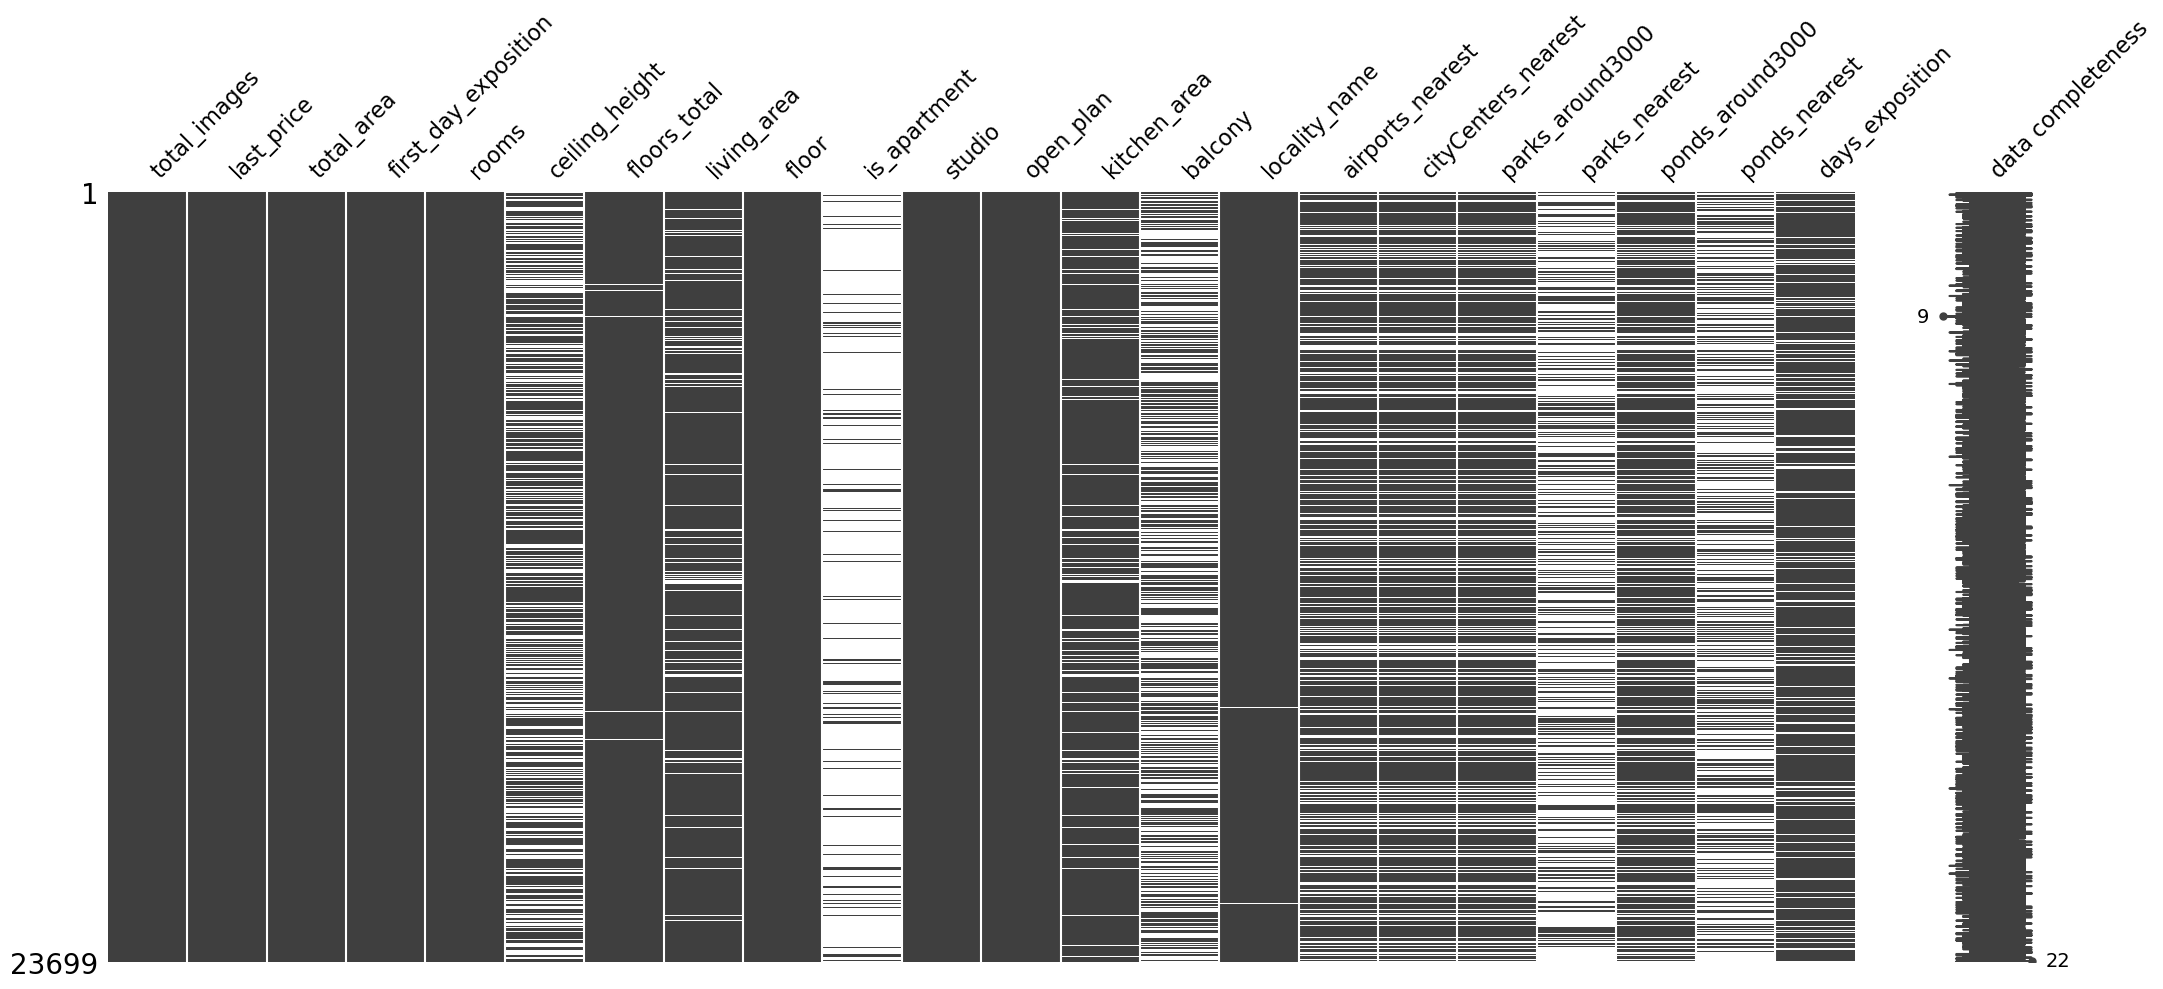

In [9]:
msno.matrix(data,labels=True)

<Axes: >

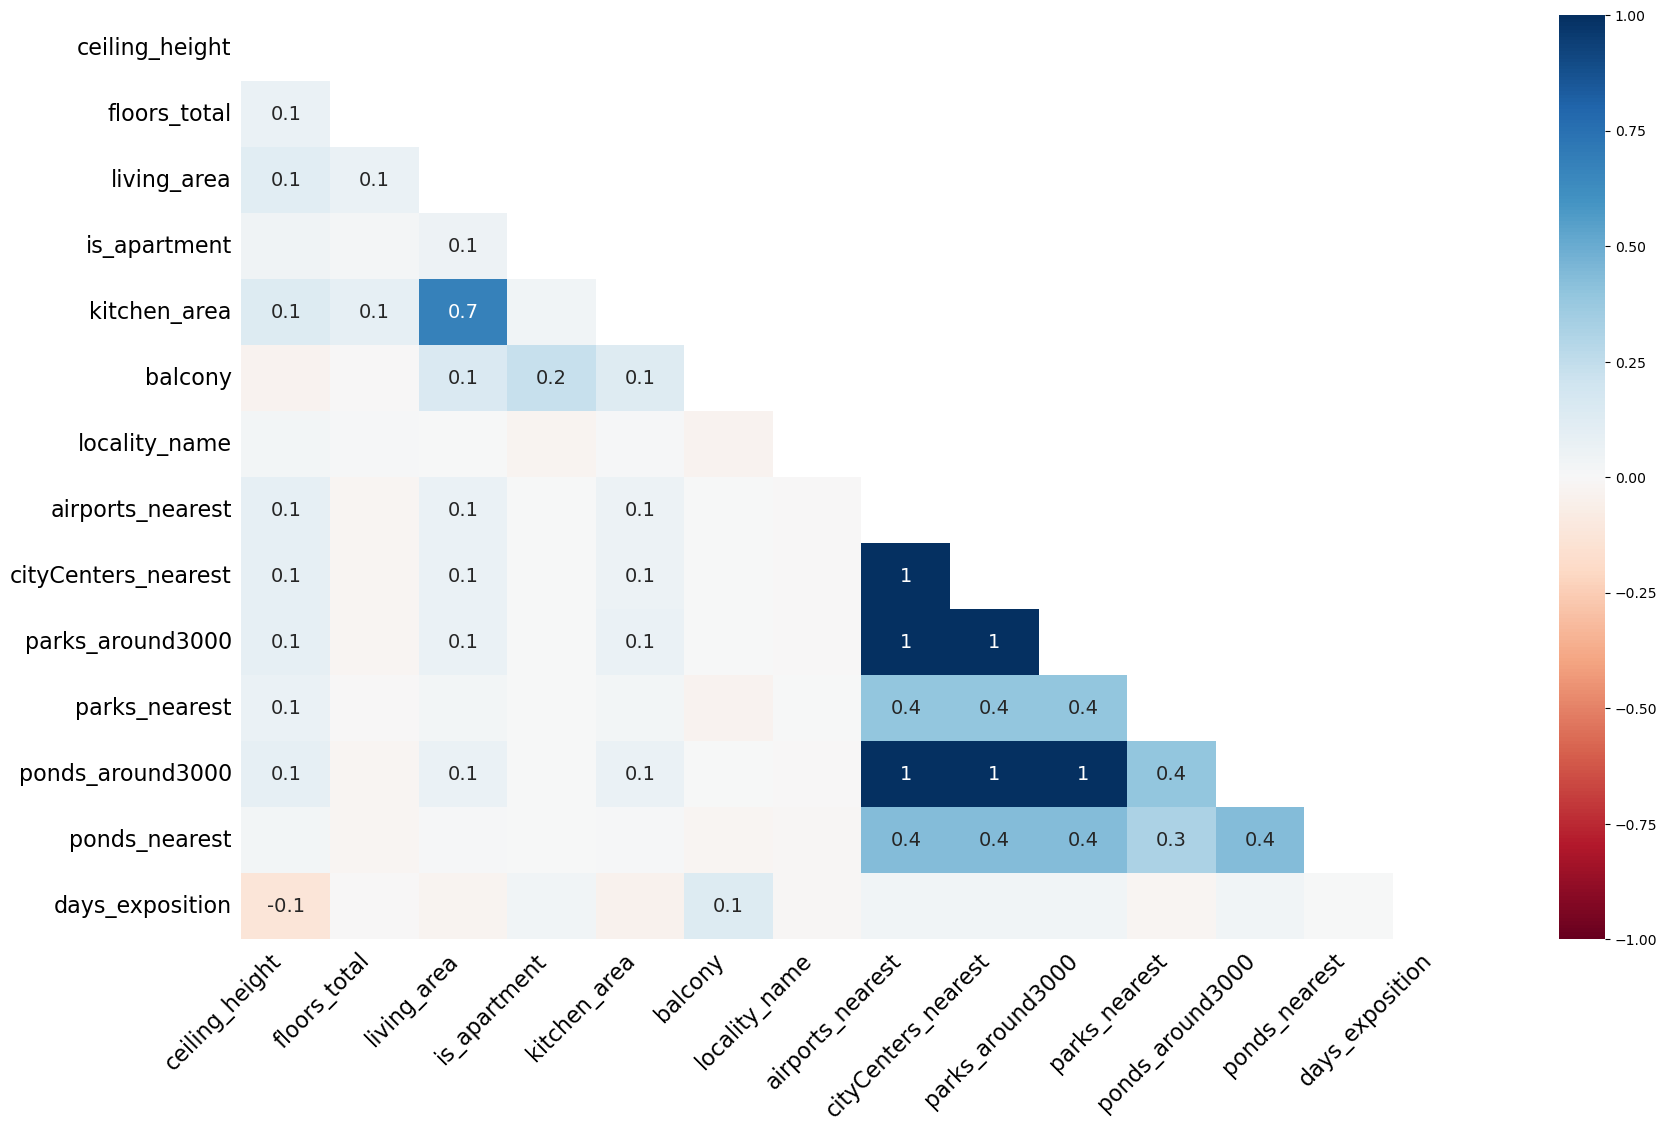

In [10]:
msno.heatmap(data)

In [11]:
# Исследование столбца is_apartment
#data['is_apartment'].value_counts()

# Проверки взаимосвязи отсутствия данных
#data[data['ponds_nearest'].isna() & data['ponds_around3000'].isna()].shape
#data[~data['ponds_nearest'].isna() & data['ponds_around3000'].isna()].head(10)
#data[data['parks_nearest'].isna() & ~data['parks_around3000'].isna()].head(10)
#data[data['parks_nearest'].isna() & data['parks_around3000'].isna()].head(10)
#data[data['ponds_around3000'].isna()]['locality_name'].value_counts().head(20)

# Исследование зависимостей пропусков столбца balcony
#data['balcony'].value_counts(dropna=False)
#data.groupby('floor')['balcony'].value_counts(dropna=False).sort_values(ascending=False).head(30)
#data['floors_total'].value_counts().sort_values(ascending=False)

# Проверка столбца ceiling_height
#data['ceiling_height'].median()
#data.pivot_table(index='locality_name',values='ceiling_height',aggfunc='median').sort_values(by='ceiling_height',ascending=False)
#data['locality_name'].value_counts().head(10)


# Проверка столбца days_exposition
#data[data['days_exposition'].isna()]['first_day_exposition'].value_counts()
#data['days_exposition'].median()

# Изучение пропусков столбца kitchen_area
#data.pivot_table(index='rooms',values='kitchen_area',aggfunc='median')
#data[(data['kitchen_area'].isna()) & (data['rooms'] == 0)].shape
#data[data['rooms'] == 0].shape

# Исследование столбца living_area
#data.pivot_table(index='rooms',values='living_area',aggfunc='median')
#data.loc[data['living_area'] == data['living_area'].max()]
#data.groupby('rooms').count()

**Результат использования библиотеки missingno**:

- Вывод матрицы пропусков визуально подчёркивает пропущенные значения. Данные лучше воспринимаются, что в классическом виде. Альтернативный вывод - использование гистограммы пропусков.
- Построив тепловую карту пропусков можно сразу сделать вывод, что пропуски допущенные в столбцах заполняемых автоматически имеют корреляцию между собой. А потому логично сделать вывод, что их причина - технический сбой. Также можем заметить сильную корреляцию между пропусками столбцов kitchen_area и living_area. 

**Выводы по пропущенным значениям:**

* Подавляющее число пропусков находится в столбце **is_apartment**. Логичнее всего предположить, что пользователи не вводили данные, если их жильё не является апартаментами. Также заметим, что из всего числа объявлений лишь 50 заявлены, как аппартаменты. Будем считать, что аппартаменты спроса не имеют и **заполним пропуски "0".** Однако, обязательно поставим галочку и уточнять информацию об отсутствии данных у тех, кто предоставил данные.

* **Parks_nearest, ponds_nearest, airports_nearest, cityCenters_nearest** заполянись автоматически, но при этом крупные части данных оказались незаполненными. Вероятнее всего имеет место техническая ошибка, которая означает отсутствие географических сведений в заданном радиусе поиска. Данный момент стоит уточнить у людей, предоставивших эти сведения, а пока будем считать, что пропуски изменять не стоит.

* В столбце **balcony** количество балконов пользователь вводит вручную. Вероятнее всего имеет место быть ошибка ввода данных. Не обнаружив взаимосвязи с другими столбцами будем считать, что **пропуски следует заполнить "0".**

* Пропущенные значения высоты потолков **ceiling_height заполним медианным значением столбца**. Это наиболее логичный и простой вариант заполнения, который наименее подвержен влиянию выбросов. Альтернативным вариантом будет заполнение медианным значением по населённым пунктам. Однако, разбиение на меньшие группы повышает риск влияния выбросов на медианное значение.

* Исследуя взаимосвязь пар столбцов **parks_nearest/parks_around3000 и ponds_neares/ponds_around3000** заметим, что пропуски в обоих столбцах идут в паре. Посему можем сделать вывод, если в диапазоне поиска столбцов /_nearest не было обнаружено парков/водоёмов, то и в радиусе 3-х километров их не будет. Заметим, что большинство пропусков допущено в объявлениях из малых населённых пунктов. Пока будем считать, что на месте пропусков в столбцах **ponds/parks_around3000** должен стоять 0, но уточним этот момент у руководства.

* **airports_nearest** заполнялся автоматически, но поскольку пропуски имеют место быть, можем предположить аналогичную ситуацию, что и со столбцами parks_nearest/ponds_nearest. В пределах диапазона поиска не было найдено аэропортов. Возможно 2 варианта действий: пропуски не трогать, либо заполнить их значением "вне диапазона", но тогда будут проблемы с построениями графиков. Поэтому, принимаем решение - **пропуски не изменять.**

* **cityCenters_nearest** автоматически заполняется, и подобно описанию проблем выше, **заполнять пропуски не стоит**.

- ***days_exposition** заполняется автоматически. Возникает вопрос: какой технический сбой мог стать причиной пропусков данных? Первый вариант: объявление всё ещё актуально, а потому даты снятия нет. Для упрощения работы **заполним пропуски медианным значением всех данных**. Однако, будем держать в списке альтернатив вариант заполнения пропусков медианным значением по году и населённому пункту. Отталкиваясь от мысли, что каждый год в каждом населённом пункте ситуация на рынке недвижимости может быть разной* **Данная идея некорректна. Пропуски занимают 15%. Заполнение медианным значением сильно изменит чашу весов.**

* **kitchen_area** следует **заполнить медианным значением группируя данные по числу комнат**. **Однако**, в случае, когда число комнат равно 0 мы получаем вариант квартиры-студии, в которой нет возможности выделить чёткую грань зоны кухни. Поскольку подобных данных меньше 1%, то на такие пропуски мы закроем глаза.

* **living_area**. Пропуски данного столбца логичнее всего заполнить по той же логике, что и столбец **kitchen_area**. **Медианным значением группы по числу комнат.** Однако, изучив данные, можем придти к выводу, что данных с большим числом комнат недостаточно, а потому такие пропуски заполнять может быть рискованно.

* **floors_total, locality_name**. Пропусков в данных столбцах крайне мало, да и повлиять на их значения мы не можем. **Оставим их без изменения.**

In [14]:
data.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.86,5.68,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6541548.77,10887013.27,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,60.35,35.65,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.07,1.08,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.77,1.26,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,10.67,6.60,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,34.46,22.03,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.89,4.89,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,10.57,5.91,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.15,1.07,0.0,0.00,1.00,2.0,5.0


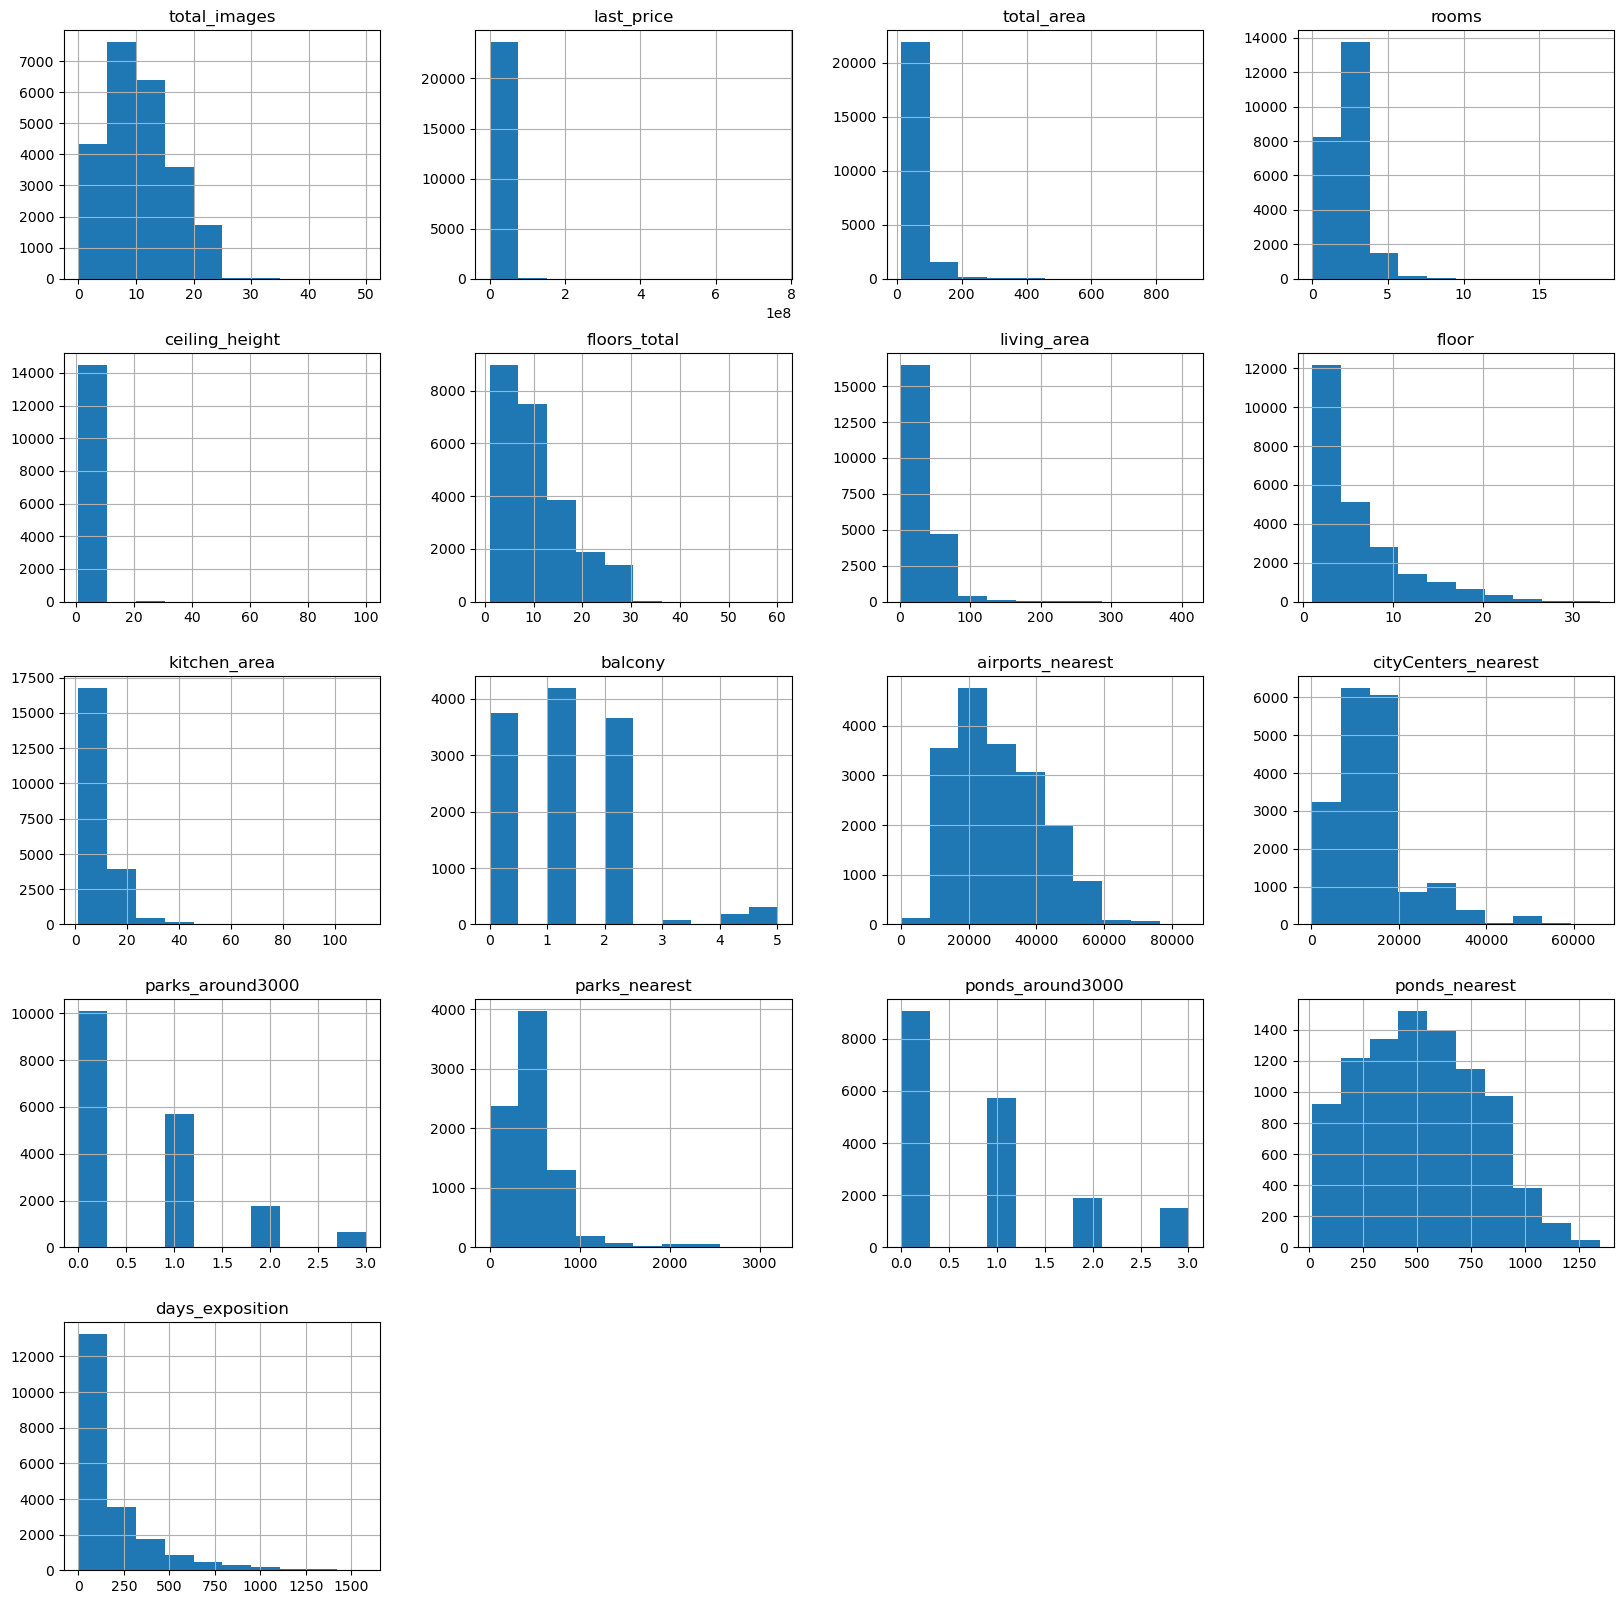

In [15]:
data.hist(figsize=(20,20))
plt.show()

**Вывод по результатам знакомства с данными**:
- Таблица состоит из 23.5 тысяч строк данных. Датафрейм весьма значительный.
- Пропуски имеют место быть. Значительное число пропусков присуще примерно половине столбцов таблицы.
- Около трети пропусков была допущена, вероятнее всего, в следствии технической ошибки.
- Изучив результат вызова describe() можем отметить, что в данных присутствуют сильные выбросы. От них нужно впоследствии избавиться, иначи они будут влиять на исследование.
- Основная часть данных столбцов стремится к Пуассоновскому распределению.

### Выполните предобработку данных

#### Заполнение пропусков

In [19]:
data['is_apartment'] = data['is_apartment'].fillna(value=0)

In [20]:
data['balcony'] = data['balcony'].fillna(0)

In [21]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [22]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)

In [23]:
#data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

Оставим пропуски столбца days_exposition. Заполнение 15% данных медианным значением может сильно изменить чашу весов в дальнейшем анализе.

In [25]:
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('rooms')['kitchen_area'].transform('median'))

In [26]:
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))

In [27]:
#data.isna().sum()
#data.query('rooms == 0').head(10)

*Заполнение пропусков произведено в соответствии с выводами прошлого раздела*

#### Преобразование типов столбцов

In [30]:
data['is_apartment'] = data['is_apartment'].astype('bool')

In [31]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)

In [32]:
#data['balcony'] = data['balcony'].astype('int')

In [33]:
#data['days_exposition'] = data['days_exposition'].astype('int')

In [34]:
#data['last_price'] = data['last_price'].astype('int')

In [35]:
update_type_columns = ['balcony', 'days_exposition', 'last_price']
for column in update_type_columns:
    data[column] = data[column].astype('int32',errors='ignore')

**Выводы по причинам преобразования типов столбцов:**
    
* **is_apartment** имеет всего 2 значения(Да/Нет), а потому ему логичен тип **bool**.
* **first_day_exposition** отвечает за дату. Для удобства работы с ней столбец был преобразован в соответствующий тип **datetime**.
* **balcony, days_exposition и last_price** принимают лишь целочисленные значения, а потому корректнее использовать соответствующий тип **int**.

#### Избавление от дубликатов

In [38]:
print(len(data['locality_name'].sort_values().unique()))
data['locality_name'].sort_values().unique()

365


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [39]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [40]:
uniq_names = {}
for name in data['locality_name'].unique():
    try:
        name_split = name.split()
        if name_split[-1] not in uniq_names:
            uniq_names[name_split[-1]] = [name]
        else:
            uniq_names[name_split[-1]].append(name)
    except:
        print(name)

nan


In [41]:
for name, duplicates in uniq_names.items():
    if len(duplicates) > 1:
        print(name, duplicates)

Мурино ['поселок Мурино', 'Мурино']
Кудрово ['деревня Кудрово', 'Кудрово']
Бор ['поселок городского типа Красный Бор', 'Сосновый Бор', 'деревня Чудской Бор', 'деревня Бор', 'деревня Трубников Бор', 'поселок Пансионат Зеленый Бор']
Федоровское ['деревня Федоровское', 'городской поселок Федоровское']
Ропша ['садовое товарищество Новая Ропша', 'поселок Ропша']
Никольское ['Никольское', 'село Никольское']
Романовка ['поселок Романовка', 'деревня Малая Романовка']
Рощино ['поселок городского типа Рощино', 'городской поселок Рощино']
Павлово ['село Павлово', 'городской поселок Павлово', 'поселок городского типа Павлово']
Советский ['поселок городского типа Советский', 'городской поселок Советский']
Ижора ['городской поселок Большая Ижора', 'поселок городского типа Большая Ижора']
Лесогорский ['городской поселок Лесогорский', 'поселок городского типа Лесогорский']
Рахья ['поселок городского типа Рахья', 'садовое товарищество Рахья']
Колпаны ['деревня Большие Колпаны', 'деревня Малые Колпаны']

In [42]:
for del_name in uniq_names.copy():
    if del_name in ['Бор', 'Романовка','Колпаны','Ладога','Бегуницы','Горка'] or len(uniq_names[del_name]) < 2:
        del uniq_names[del_name]

In [43]:
for name, duplicates in uniq_names.items():
        data['locality_name'] = data['locality_name'].replace(duplicates[1:],duplicates[0])

In [44]:
print(len(data['locality_name'].sort_values().unique()))
data['locality_name'].sort_values().unique()

305


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Лодейное Поле', 'Ломоносов', 'Луга',
       'Любань', 'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск',
       'Петергоф', 'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск',
       'Пушкин', 'Санкт-Петербург', 'Светогорск', 'Сертолово',
       'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин',
       'Тосно', 'Шлиссельбург', 'городской поселок Большая Ижора',
       'городской поселок Будогощь', 'городской поселок Виллози',
       'городской поселок Лесогорский', 'городской поселок Мга',
       'городской поселок Назия', 'городской поселок Новоселье',
       'городской поселок Свирьстрой', 'городской поселок Янино-1',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревн

Вероятнее всего выше был использован сложный способ удаления неявных дубликатов. Таким методом мы сохраняем указанный тип населённого пункта(село/ПГС, поселок, деревня и т.д). Работа выполнена следующим образом:

* 1) Выведя наименования пунктов, была обнаружена буква "ё", которая создавала ряд дубликатов.  Заменили её.
* 2) Обратив внимание на записи, заметим, что название населённого пункта хранится, как правило, последним словом. 
* 3) Созданим словарь уникальных наименования по последнему слову записи.
* 4) Проанализировав полученный словарь заметим, что есть несколько пунктов имеющим наименование из нескольких слов.
* 5) Удалим неподходящие наименования - те, что встречались лишь единожды.
* 6) Проведём замену оставшихся записией - первой записью заменим все оставшиеся.

Альтернативный способ замены неявных дубликатов - избавиться от типа населённого пункта.
Создадим новый столбец на основе этой идеи:

In [46]:
types_locality_name = ['коттеджный поселок ', 
                       'поселок городского типа ',
                       'поселок станции ',
                       'деревня ',
                       'село ',
                       'садоводческое некоммерческое товарищество ',
                       'садовое товарищество ',
                       'городской поселок ', 
                       'поселок ']
data['unique_locality_name'] = data['locality_name'].replace(types_locality_name,'',regex=True)

**Выводы после удаления неявных дубликатов:** было использовано 2 способа удаления дубликатов.
    
    1) - Удаление дубликатов через словарь с сохранением типа населенного пункта.
    2) - Удаление дубликатов путём стирания указанного типа населённого пункта.

Из 365 значений осталось лишь 305. **Порядка 20% наименовай являлись неявными дубликатами.** Достаточно большой показатель.

**Вывод по результату этапа предобработки**:

- Были заполнены основные пропуски. Нетронутыми остались те столбцы, которые некорректно будет заполнять имеющимися данными. Вполне возможно, что на месте пропусков могли быть значения сильно отличинающиеся от предполагаемых.
- Четверти столбцов был изменён тип данных на более корректный.
- Избавление от неявных дубликатов позволило избавиться от порядка 20% наименований населённых пунктов.

### Добавьте в таблицу новые столбцы

In [50]:
data['price_OneMS'] = (data['last_price'] / data['total_area']).round(2)

In [51]:
data['weekday'] = data['first_day_exposition'].dt.weekday

In [52]:
data['month'] = data['first_day_exposition'].dt.month

In [53]:
data['year'] = data['first_day_exposition'].dt.year

In [54]:
def floor_typing(row):
    total_floor = row['floors_total']
    floor = row['floor']
    if floor == 1: return 'первый'
    elif floor == total_floor: return 'последний'
    else: return 'другой'
data['floor_type'] = data.apply(floor_typing,axis=1)

In [55]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] // 1_000

**Выводы после добавления новых столбцов:** были добавлены новые столбцы для удобства дальнейшей группировки и анализа данных.

Введены следующие столбцы:
* Цена метра квадратного - **price_OneMS**.
* День недели публикации - **weekday**.
* Месяц публикации - **month**.
* Год публикации - **year**.
* Определён тип этажа - **floor_type**. Возможные значений - первый, последний и другой.
* Расстояние до центра города в километрах - **cityCenters_nearest_km**.

При создании столбцов большим плюсом стало преобразование типа столбца *first_day_exposition* в DateTime, выполненное разделом ранее.

### Проведите исследовательский анализ данных

#### Обзор основных параметров

In [59]:
data.describe().round(2).transpose()

,count,mean,min,25%,50%,75%,max,std
total_images,23699.0,9.86,0.0,6.0,9.0,14.0,50.0,5.68
last_price,23699.0,6541548.77,12190.0,3400000.0,4650000.0,6800000.0,763000000.0,10887013.27
total_area,23699.0,60.35,12.0,40.0,52.0,69.9,900.0,35.65
first_day_exposition,23699,2017-11-08 21:55:18.975484160,2014-11-27 00:00:00,2017-05-12 12:00:00,2017-12-12 00:00:00,2018-08-26 00:00:00,2019-05-03 00:00:00,NaN
rooms,23699.0,2.07,0.0,1.0,2.0,3.0,19.0,1.08
ceiling_height,23699.0,2.72,1.0,2.6,2.65,2.7,100.0,0.99
floors_total,23613.0,10.67,1.0,5.0,9.0,16.0,60.0,6.6
living_area,23699.0,34.32,2.0,18.4,30.3,42.7,409.7,21.7
floor,23699.0,5.89,1.0,2.0,4.0,8.0,33.0,4.89
kitchen_area,23502.0,10.46,1.3,7.3,9.04,11.5,112.0,5.66


##### Общая площадь - total_area. 

Можем заметить, что более 95% записией не превосходят показателя в 125м^2. При этом, объявления, где площадь более 250м^2, стоят особняком, являясь аномалиями. Удалим такие значения, а также все строки показатель общей площади которых превышает 125м^2. Также подозрительными являются объявления, с площадью менее 20м^2. Вероятнее всего речь идёт о продаже доли. Однозначно назвать такие данные аномальными мы не может, а потому оставим их.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


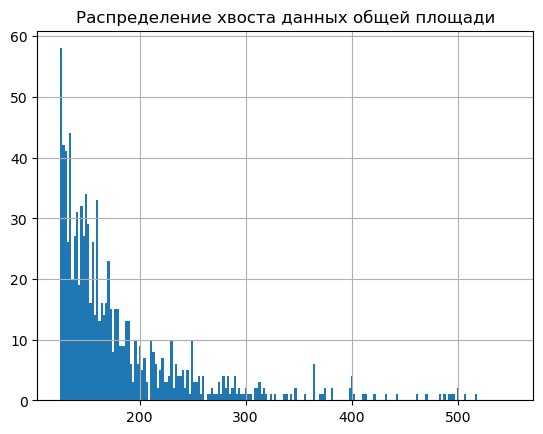

(942, 29)

In [61]:
print(data['total_area'].describe())
data['total_area'].hist(range=(125,550),bins=200)
plt.title('Распределение хвоста данных общей площади')
plt.show()
data.query('total_area > 125').shape

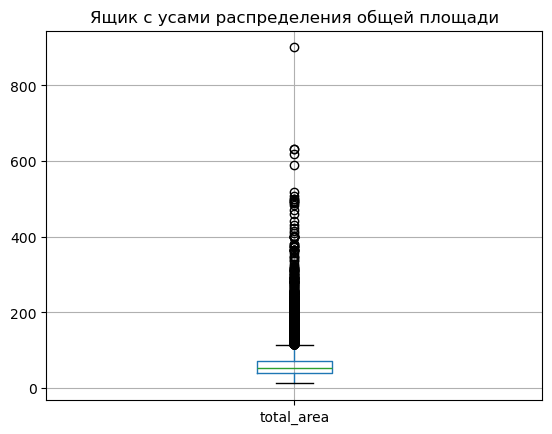

In [62]:
data.boxplot(column='total_area')
plt.title('Ящик с усами распределения общей площади')
plt.show()

In [63]:
data = data.drop(data.query('total_area > 125').index)

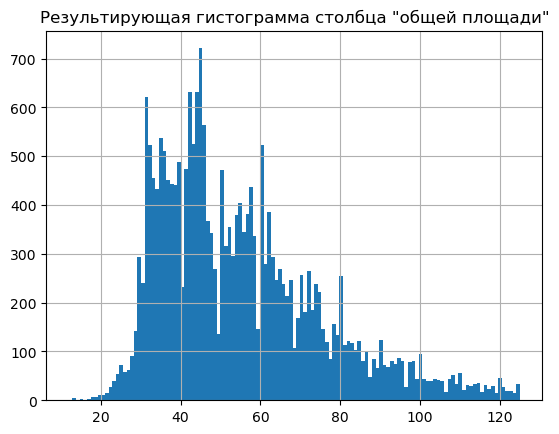

count    22757.000000
mean        55.219229
std         20.639876
min         12.000000
25%         39.700000
50%         50.700000
75%         66.500000
max        125.000000
Name: total_area, dtype: float64


In [64]:
data['total_area'].hist(bins=125)
plt.title('Результирующая гистограмма столбца "общей площади"')
plt.show()
print(data['total_area'].describe())

##### Жилая площадь - living_area.

Изучив гистограмму распределения можем заметить, что в диапазоне до 60м^2 имеется несколько пиков. Такую ситуацию можем объяснить зависимостью от числа комнат. В подтверждение этого провели сравнение сводной таблицы и гистограммы. 
Объявлений с жилой площадью больше 75 крайне мало, а потому на общем фоне они выглядят как редкие значения. Уберём их.

count    22757.000000
mean        31.491158
std         14.098420
min          2.000000
25%         18.100000
50%         30.000000
75%         41.000000
max        145.000000
Name: living_area, dtype: float64


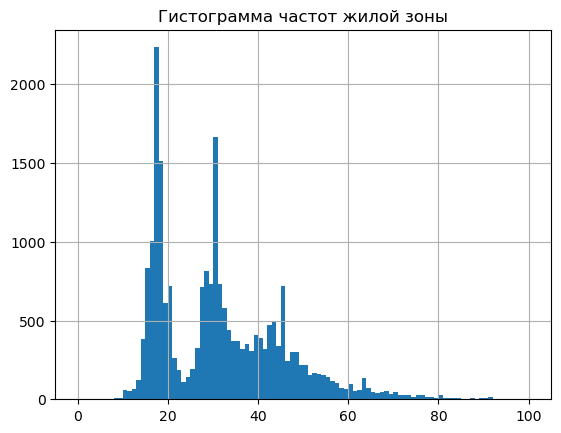

In [66]:
print(data['living_area'].describe())
data['living_area'].hist(range=(0,100), bins=100)
plt.title('Гистограмма частот жилой зоны')
plt.show()

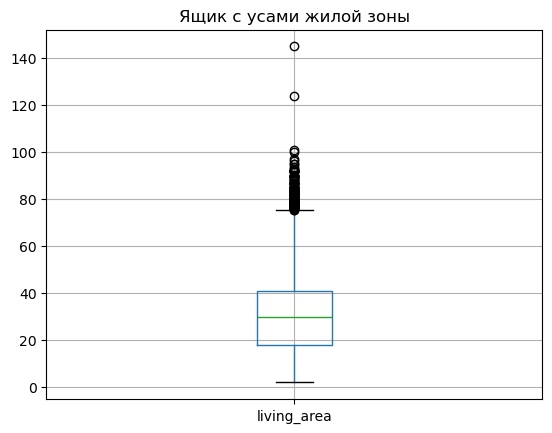

In [67]:
data.boxplot(column='living_area')
plt.title('Ящик с усами жилой зоны')
plt.show()

In [68]:
data.pivot_table(index='rooms',values='living_area',aggfunc='mean')

,living_area
rooms,
0,18.807857
1,17.861775
2,31.600663
3,46.176429
4,58.626965
5,72.322130
6,83.223077
7,113.500000


In [69]:
data = data.drop(data.query('living_area > 75').index)

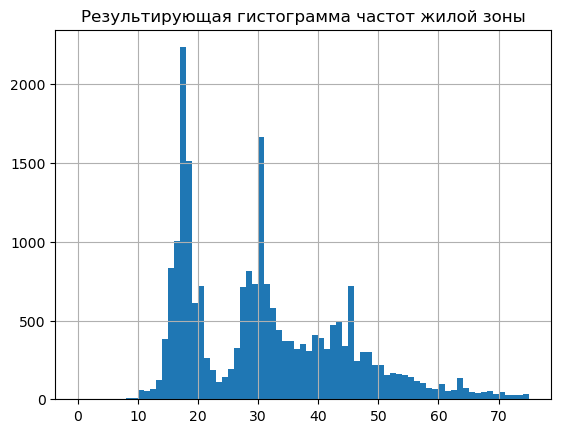

In [70]:
data['living_area'].hist(range=(0,75), bins=75)
plt.title('Результирующая гистограмма частот жилой зоны')
plt.show()

##### Площадь кухни - kitchen_area
*Плывущий хвост* задают нетипичные объявления с большой жилой площадью. Проведя больше исследований примем решение - избавиться от таких объявлений, по причине их малого числа. На текущем этапе избавимся от редких показателей - значений выше 20м^2.

In [72]:
data['kitchen_area'].describe()

count    22383.000000
mean         9.933195
std          4.391880
min          1.300000
25%          7.100000
50%          9.000000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64

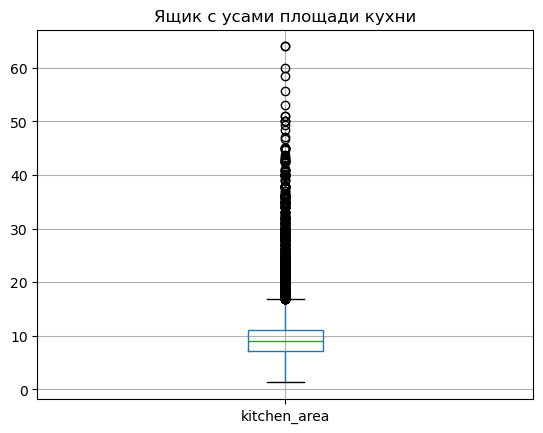

In [73]:
data.boxplot(column='kitchen_area')
plt.title('Ящик с усами площади кухни')
plt.show()

In [74]:
data.query('kitchen_area > 20').shape

(632, 29)

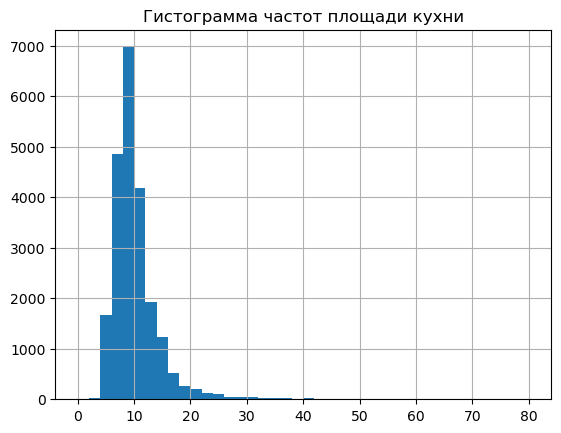

In [75]:
data['kitchen_area'].hist(range=(0,80),bins=40)
plt.title('Гистограмма частот площади кухни')
plt.show()

count    21751.000000
mean         9.419434
std          2.999952
min          1.300000
25%          7.000000
50%          9.000000
75%         11.000000
max         20.000000
Name: kitchen_area, dtype: float64


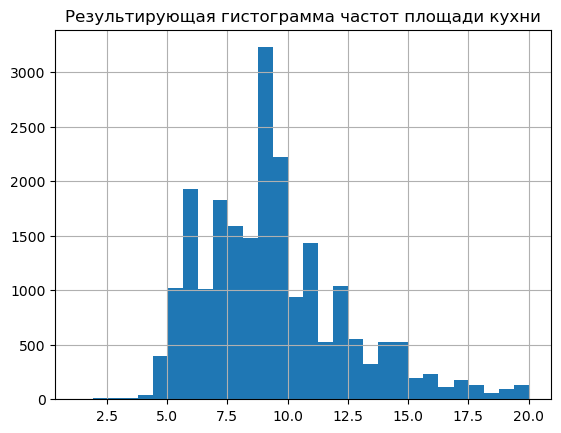

In [76]:
data = data.drop(data.query('kitchen_area > 20').index)
print(data['kitchen_area'].describe())
data['kitchen_area'].hist(bins=30)
plt.title('Результирующая гистограмма частот площади кухни')
plt.show()

##### Цена объекта - last_price

Обрубив множество концов на прошлых этапах, можем заметить, что разброс значений порядком уменьшился. Однако, хвост справа все ещё имеет место быть. Редкие значения нам ни к чему, а потому, провдя ряд проверок можем принять решение, что основная стоимость квартир не превышает показателя в 15 миллионов. Всё остальное - уберём.

In [78]:
data['last_price'].describe()

count    2.194700e+04
mean     5.202885e+06
std      3.359279e+06
min      4.300000e+05
25%      3.340000e+06
50%      4.480000e+06
75%      6.180000e+06
max      1.240000e+08
Name: last_price, dtype: float64

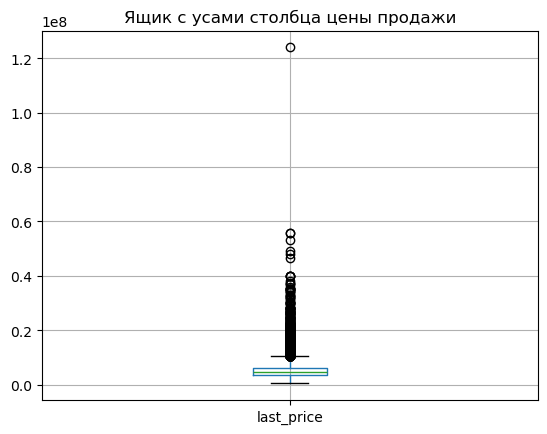

In [79]:
data.boxplot(column='last_price')
plt.title('Ящик с усами столбца цены продажи')
plt.show()

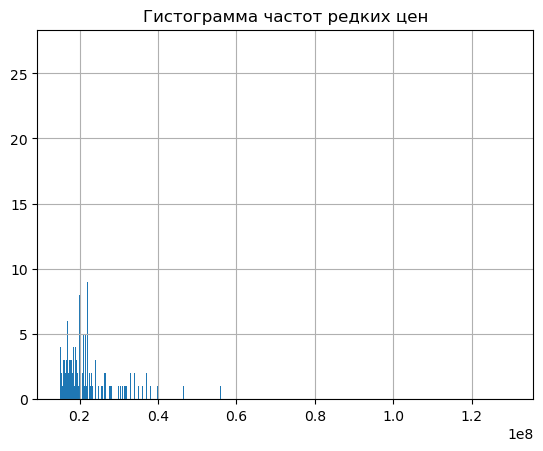

In [80]:
data['last_price'].hist(range=(15_000_000,130_000_000),bins=1000)
plt.title('Гистограмма частот редких цен')
plt.show()

In [81]:
data.sort_values(by='last_price',ascending=False).head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,unique_locality_name,price_OneMS,weekday,month,year,floor_type,cityCenters_nearest_km
4996,20,124000000,124.5,2017-10-12,4,3.00,4.0,67.2,2,False,False,False,20.00,0,Санкт-Петербург,20399.0,1722.0,3.0,302.0,3.0,172.0,45.0,Санкт-Петербург,995983.94,3,10,2017,другой,1.0
13685,20,55845000,124.1,2015-12-28,2,2.65,9.0,50.0,2,False,False,False,20.00,0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,378.0,Санкт-Петербург,450000.00,0,12,2015,другой,2.0
1944,8,55800000,125.0,2015-12-17,2,3.20,9.0,50.0,2,False,False,False,20.00,0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,481.0,Санкт-Петербург,446400.00,3,12,2015,другой,2.0
10011,3,53000000,90.0,2019-03-21,3,3.15,5.0,73.0,3,False,False,False,12.00,0,Санкт-Петербург,24698.0,2385.0,3.0,389.0,3.0,564.0,40.0,Санкт-Петербург,588888.89,3,3,2019,другой,2.0
18770,20,49000000,125.0,2019-01-29,3,2.91,6.0,73.9,6,False,False,False,9.70,1,Санкт-Петербург,33173.0,6030.0,3.0,614.0,3.0,258.0,NaN,Санкт-Петербург,392000.00,1,1,2019,последний,6.0
7136,0,48000000,108.0,2018-02-01,3,2.65,5.0,61.0,2,False,False,False,13.50,0,Санкт-Петербург,24632.0,3180.0,1.0,551.0,3.0,415.0,144.0,Санкт-Петербург,444444.44,3,2,2018,другой,3.0
11492,1,46424072,92.4,2014-12-09,2,2.65,6.0,54.8,6,True,False,False,20.00,1,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1030.0,Санкт-Петербург,502425.02,1,12,2014,последний,0.0
7596,18,40000000,110.0,2018-02-19,3,3.20,4.0,74.4,2,False,False,False,12.00,0,Санкт-Петербург,23197.0,2383.0,2.0,339.0,1.0,93.0,NaN,Санкт-Петербург,363636.36,0,2,2018,другой,2.0
6127,13,40000000,65.3,2017-07-13,2,4.10,5.0,45.0,2,False,False,False,12.00,2,Санкт-Петербург,23308.0,2380.0,1.0,473.0,1.0,283.0,497.0,Санкт-Петербург,612557.43,3,7,2017,другой,2.0
12916,6,39990000,67.7,2015-06-25,3,3.10,7.0,42.9,6,False,False,False,9.00,0,Санкт-Петербург,25685.0,2136.0,1.0,72.0,3.0,202.0,NaN,Санкт-Петербург,590694.24,3,6,2015,другой,2.0


In [82]:
data.query('last_price > 15_000_000').shape

(312, 29)

In [83]:
data = data.drop(data.query('last_price > 15_000_000 or last_price < 400_000').index)

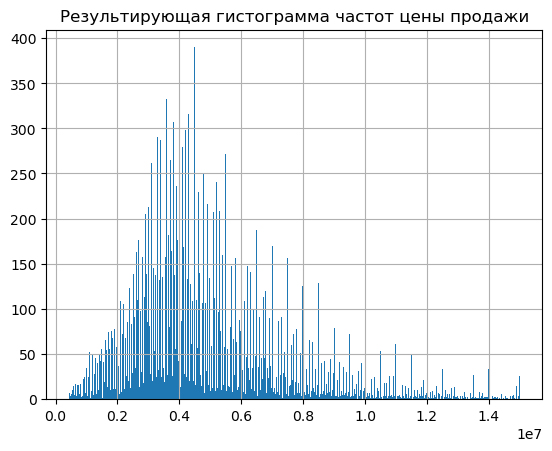

In [84]:
data['last_price'].hist(bins=500)
plt.title('Результирующая гистограмма частот цены продажи')
plt.show()

##### Количество комнат - rooms.
Обрубая концы у нас осталось крайне мало данных о 5-ти и 6-ти комнатной недвижимости. Но данные сведения нам понадобятся, не станем их группировать или удалять. Вариант с 0 числом комнат также оставим, это достаточно простой способ отделить студию от 1-комнатной квартиры.

In [86]:
data['rooms'].describe()

count    21635.000000
mean         1.929050
std          0.895432
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

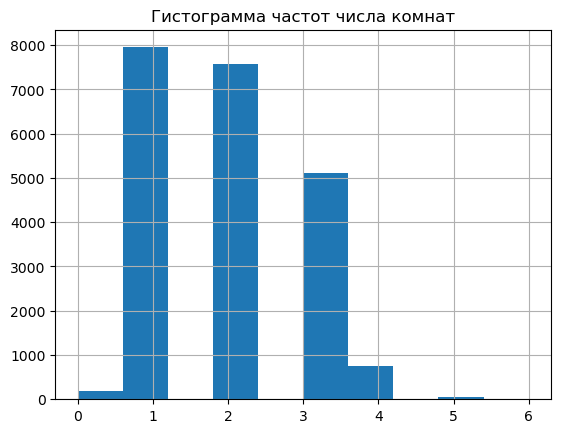

In [87]:
data['rooms'].hist()
plt.title('Гистограмма частот числа комнат')
plt.show()

In [88]:
data.query('rooms in [5,6]').shape

(66, 29)

In [89]:
#data.loc[data['rooms'] == 0, 'rooms'] = 1
#data.loc[data['rooms'] >= 4,'rooms'] = '4+'
#data['rooms'] = data['rooms'].astype('str')
#data['rooms'].hist()

##### Высота потолков - ceiling_height
При знакомстве с данными в начале работы были видны явные выбросы(встречались объявления с потолками 20+м). 
Вероятнее всего - человеческий фактор стал причиной таких аномалий. Исправим данную ситуцию уменьшив столь высокии показатели в 10 раз. Объявления, в котором высота потолков не менее 6 - отбросим, по причине их редкости.

In [91]:
data['ceiling_height'].describe()

count    21635.000000
mean         2.703432
std          1.025186
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

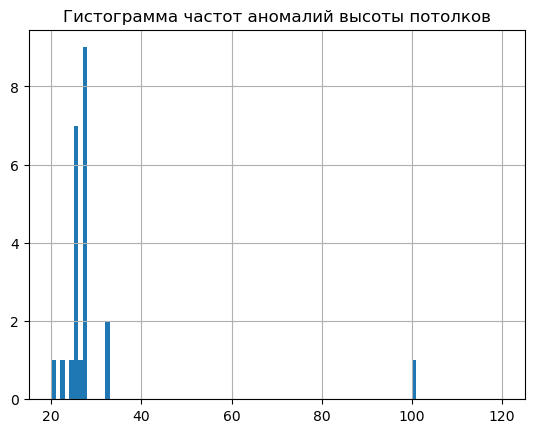

In [92]:
data['ceiling_height'].hist(range=(20,120),bins=100)
plt.title('Гистограмма частот аномалий высоты потолков')
plt.show()

In [93]:
data.query('ceiling_height >= 6').shape

(29, 29)

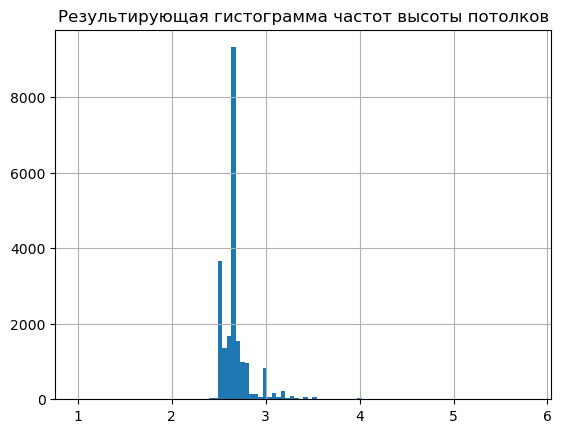

In [94]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] / 10
data = data.drop(data.query('ceiling_height >= 6').index)
data['ceiling_height'].hist(bins=100)
plt.title('Результирующая гистограмма частот высоты потолков')
plt.show()

##### Тип этажа квартиры - floors_type.

Исследуя гистограмму, каких-либо особенностей заметить не удалось. Все данные логично распределены. Основное количество объявлений принадлежит "средним этажам".

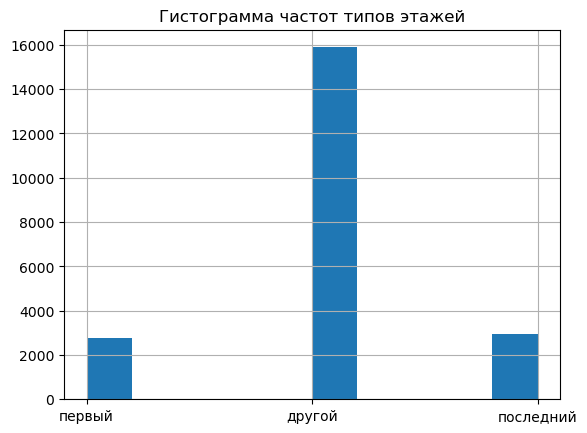

In [96]:
data['floor_type'].hist()
plt.title('Гистограмма частот типов этажей')
plt.show()

##### Общее количество этажей в доме - floors_total

Полагаясь на гистограмму и ящик с усами делаем вывод, что здания имеющие более 30 этажей сильно выделяются на общем фоне. Уберём такие сведения из датафрейма.

In [98]:
data['floors_total'].describe()

count    21551.000000
mean        10.801819
std          6.632076
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

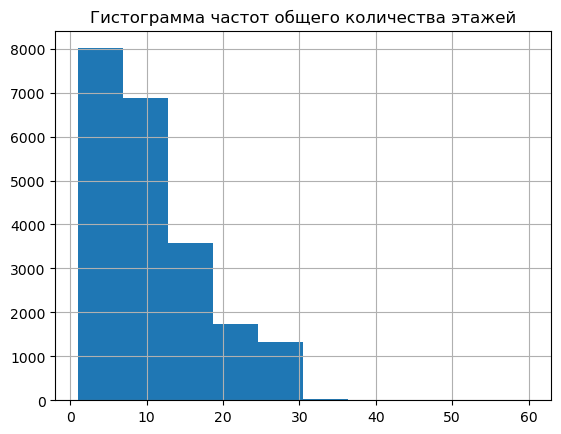

In [99]:
data['floors_total'].hist()
plt.title('Гистограмма частот общего количества этажей')
plt.show()

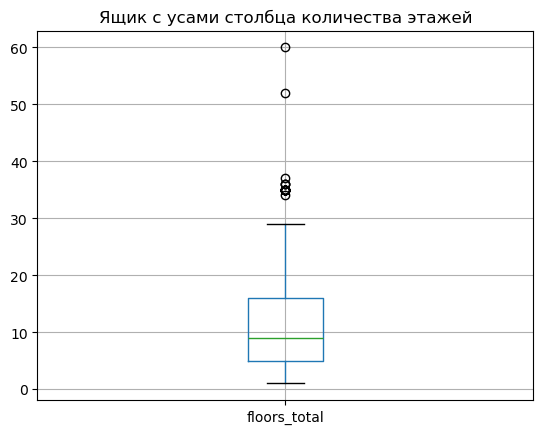

In [100]:
data.boxplot(column='floors_total')
plt.title('Ящик с усами столбца количества этажей')
plt.show()

In [101]:
data = data.drop(data.query('floors_total > 30').index)

##### Расстояние до центра города в метрах - cityCenters_nearest

Общее исследование показывает, что расстояние больше 35_000 является сильной аномалией. Удалим строки превышающией этот лимит. 

In [103]:
data['cityCenters_nearest'].describe()

count    16214.000000
mean     14863.269952
std       8495.921918
min        208.000000
25%      10503.750000
50%      13515.000000
75%      16638.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

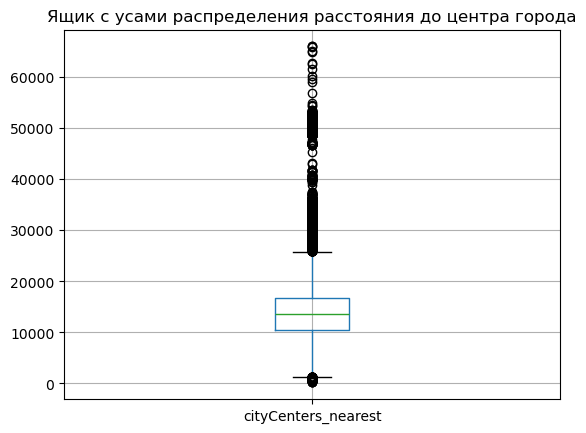

In [104]:
data.boxplot(column='cityCenters_nearest')
plt.title('Ящик с усами распределения расстояния до центра города')
plt.show()

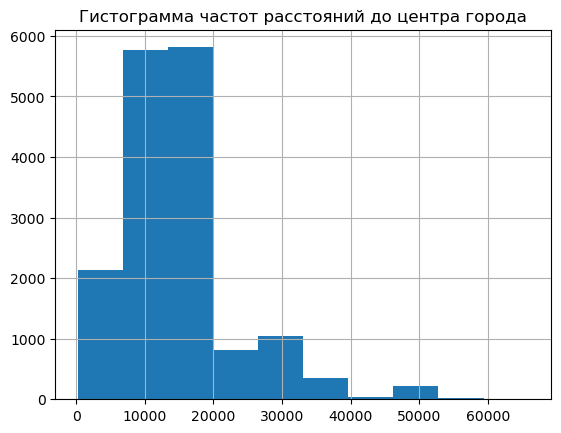

In [105]:
data['cityCenters_nearest'].hist()
plt.title('Гистограмма частот расстояний до центра города')
plt.show()

In [106]:
print(data.query('cityCenters_nearest >= 35_000').shape)
data = data.drop(data.query('cityCenters_nearest >= 35_000').index)

(400, 29)


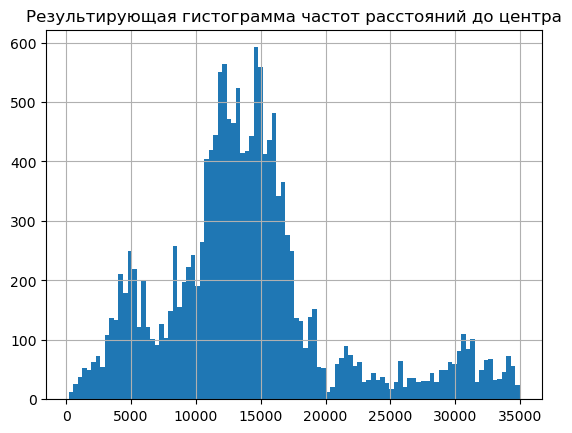

In [107]:
data['cityCenters_nearest'].hist(bins=100)
plt.title('Результирующая гистограмма частот расстояний до центра')
plt.show()

##### Расстояние до ближайшего парка - parks_nearest

Выбивающимся значениями на общем фоне стали объявления, в которых расстояние до парка более 1.2км. Таким объявлений не много, около 1%, от общего числа, а потому без зазрения совести можем удалить их. Вполне возможно, что ситуация приняла бы иной оборот, если бы пропущенных значений было меньше.

In [109]:
data['parks_nearest'].describe()

count    6676.000000
mean      493.429748
std       333.129971
min         1.000000
25%       295.000000
50%       458.000000
75%       618.000000
max      3190.000000
Name: parks_nearest, dtype: float64

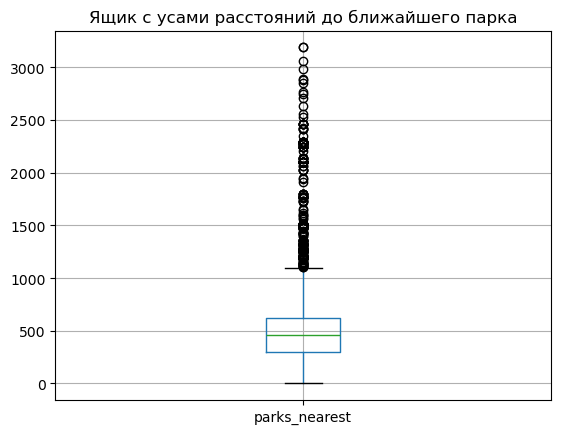

In [110]:
data.boxplot(column='parks_nearest')
plt.title('Ящик с усами расстояний до ближайшего парка')
plt.show()

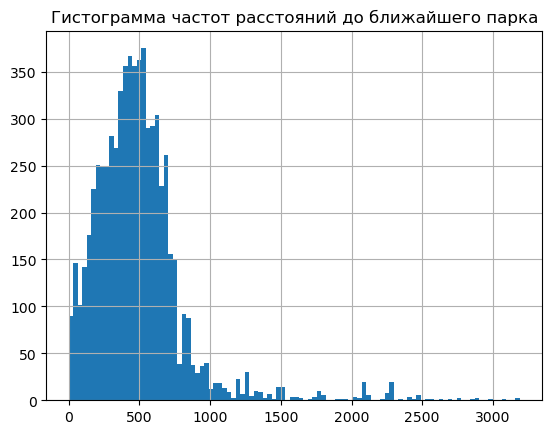

In [111]:
data['parks_nearest'].hist(bins=100)
plt.title('Гистограмма частот расстояний до ближайшего парка')
plt.show()

In [112]:
data.query('parks_nearest > 1200').shape

(215, 29)

In [113]:
data = data.drop(data.query('parks_nearest > 1200').index)

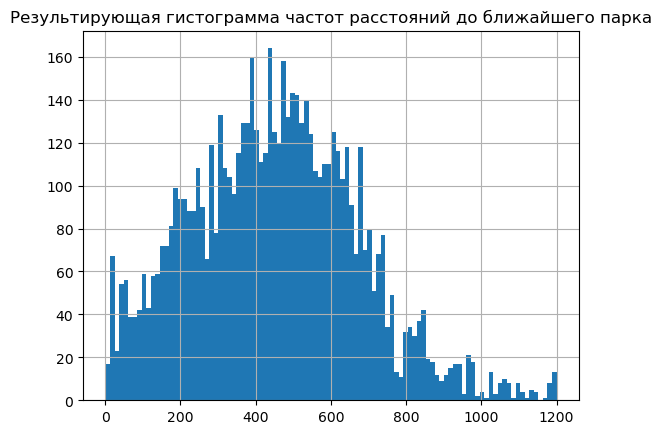

In [114]:
data['parks_nearest'].hist(bins=100)
plt.title('Результирующая гистограмма частот расстояний до ближайшего парка')
plt.show()

In [115]:
data.describe().round(2).transpose()

,count,mean,min,25%,50%,75%,max,std
total_images,20988.0,9.72,0.0,6.0,9.0,14.0,39.0,5.56
last_price,20988.0,4958702.02,430000.0,3300000.0,4400000.0,6000000.0,15000000.0,2493755.41
total_area,20988.0,53.21,12.0,39.0,49.5,64.0,125.0,18.47
first_day_exposition,20988,2017-11-18 02:33:12.452830208,2014-11-27 00:00:00,2017-05-24 00:00:00,2017-12-18 00:00:00,2018-08-30 00:00:00,2019-05-03 00:00:00,NaN
rooms,20988.0,1.93,0.0,1.0,2.0,3.0,6.0,0.9
ceiling_height,20988.0,2.67,1.0,2.6,2.65,2.7,5.8,0.18
floors_total,20914.0,10.86,1.0,5.0,9.0,16.0,29.0,6.59
living_area,20988.0,30.57,2.0,18.0,29.8,39.9,75.0,12.98
floor,20988.0,5.94,1.0,2.0,4.0,8.0,27.0,4.91
kitchen_area,20795.0,9.36,1.3,7.0,9.0,11.0,20.0,2.93


**Итоги исследования основных параметров**

- После удаления аномалий и редких значений число записей стало на 10% меньше.
- Наибольшему влиюянию аномалий был подтвержен столбец **last_price**.
- Столбец значения которого могут сильно поменяться из-за пропусков - **parks_nearest**.
- После проведения процесса удаления аномалий и редких значений данные приняли сбалансированный вид. По таким показателям уже можно делать выводы зависимостей.

#### Изучение скорости продажи квартир - days_exposition

In [118]:
data['days_exposition'].describe()

count    18395.000000
mean       171.503452
std        209.282144
min          1.000000
25%         44.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64

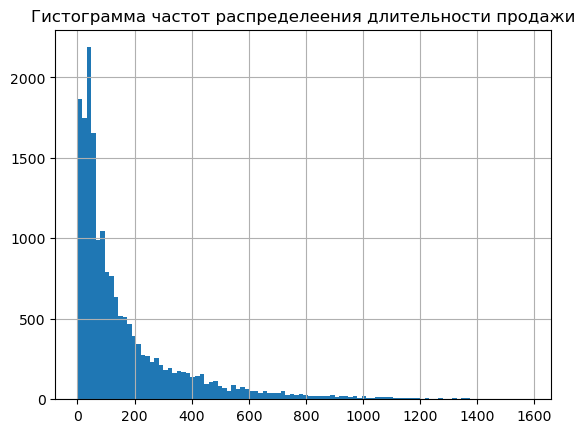

In [119]:
data['days_exposition'].hist(bins=100)
plt.title('Гистограмма частот распределеения длительности продажи')
plt.show()

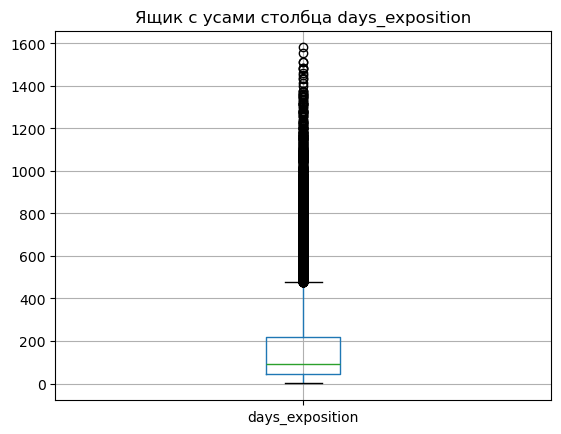

In [120]:
data.boxplot(column='days_exposition')
plt.title('Ящик с усами столбца days_exposition')
plt.show()

In [121]:
data['days_exposition'].median()

91.0

In [122]:
data['days_exposition'].mean()

171.5034520250068

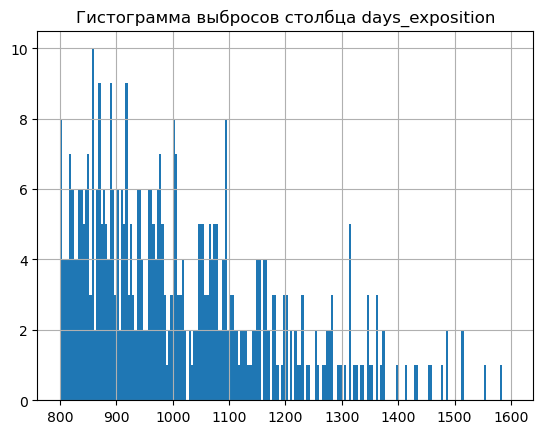

In [123]:
data['days_exposition'].hist(range=(800,1600),bins=200)
plt.title('Гистограмма выбросов столбца days_exposition')
plt.show()

In [124]:
data.query('days_exposition > 1100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,unique_locality_name,price_OneMS,weekday,month,year,floor_type,cityCenters_nearest_km
353,4,5990000,43.5,2015-05-08,1,3.00,5.0,25.00,4,False,False,False,9.40,0,Санкт-Петербург,10527.0,10278.0,1.0,93.0,0.0,NaN,1292.0,Санкт-Петербург,137701.15,4,5,2015,другой,10.0
398,7,12789000,79.3,2014-12-09,2,3.00,8.0,43.10,5,False,False,False,17.60,0,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,1345.0,Санкт-Петербург,161273.64,1,12,2014,другой,11.0
437,12,3350000,37.0,2015-02-24,1,2.55,6.0,17.80,6,False,False,False,8.40,0,Петергоф,46151.0,34044.0,1.0,185.0,1.0,755.0,1273.0,Петергоф,90540.54,1,2,2015,последний,34.0
459,13,5200000,51.0,2016-03-02,2,2.55,9.0,32.00,5,False,False,False,6.00,0,Санкт-Петербург,48522.0,16360.0,0.0,NaN,0.0,NaN,1153.0,Санкт-Петербург,101960.78,2,3,2016,другой,16.0
749,6,4150000,30.8,2015-03-19,1,2.60,17.0,15.40,3,False,False,False,8.70,0,Санкт-Петербург,32968.0,14132.0,1.0,157.0,1.0,232.0,1336.0,Санкт-Петербург,134740.26,3,3,2015,другой,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23052,5,11446000,90.9,2015-05-25,3,2.70,19.0,56.90,3,False,False,False,10.70,2,Санкт-Петербург,19499.0,4844.0,0.0,NaN,1.0,503.0,1201.0,Санкт-Петербург,125918.59,0,5,2015,другой,4.0
23055,8,3200000,33.0,2016-03-18,1,2.65,24.0,13.05,3,False,False,False,9.75,0,поселок Шушары,13461.0,19247.0,0.0,NaN,1.0,351.0,1130.0,Шушары,96969.70,4,3,2016,другой,19.0
23212,9,7515162,58.8,2015-03-10,2,2.65,10.0,30.40,3,False,False,False,11.10,0,Санкт-Петербург,23604.0,5294.0,0.0,NaN,1.0,434.0,1239.0,Санкт-Петербург,127808.88,1,3,2015,другой,5.0
23248,5,4900000,80.0,2014-12-25,3,2.65,15.0,47.00,14,False,False,False,9.00,2,поселок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,1187.0,Мурино,61250.00,3,12,2014,другой,NaN


Вероятнее всего подобные аномалии появились из-за того, что продавцы либо поставили слишком высокую стоимость, либо забыли снять объявление после продажи, и оно автоматически ежемесячно продлевалось.

In [126]:
data = data.drop(data.query('days_exposition > 1100').index)

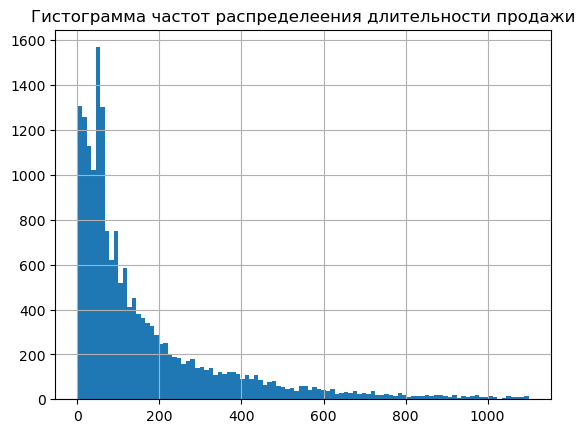

In [127]:
data['days_exposition'].hist(bins=100)
plt.title('Гистограмма частот распределеения длительности продажи')
plt.show()

In [128]:
data['days_exposition'].describe()

count    18282.000000
mean       164.860956
std        191.850715
min          1.000000
25%         43.000000
50%         90.000000
75%        213.000000
max       1100.000000
Name: days_exposition, dtype: float64

**Вывод исследования скорости продажи квартир:**

Большинство объявлений снимают в течение *200 дней*. Основываясь на гистограмме и ящике с усами можно выделить следующие группы продаж:
    
***Быстрыми*** продажи можно считать, если длительность продажи не превышает показателя медианы - 95 дней.

К ***Необычно долгим*** продажи можно отнести в случае, если их длительность заняла больше года. ~400+ дней.

#### Определиние факторов, которые больше всего влияют на общую (полную) стоимость объекта.

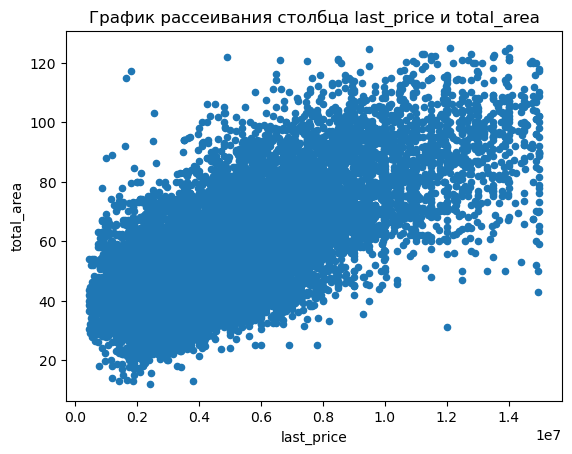

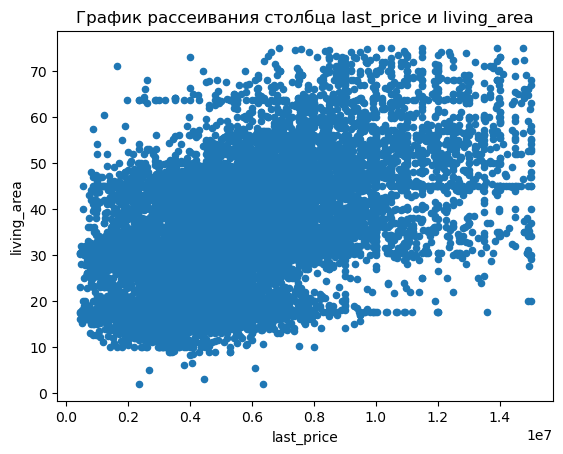

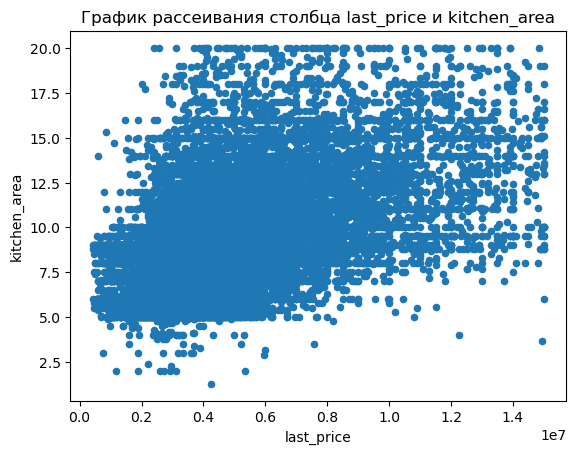

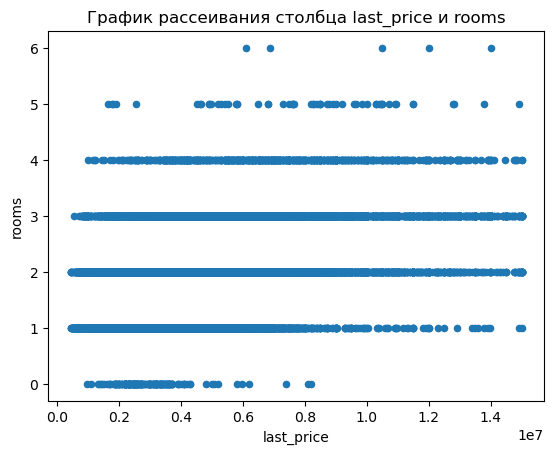

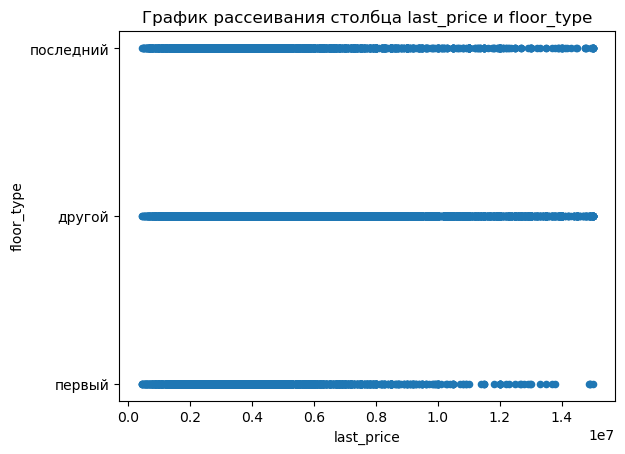

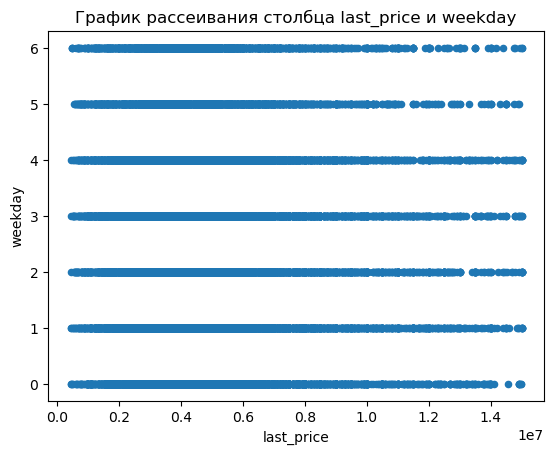

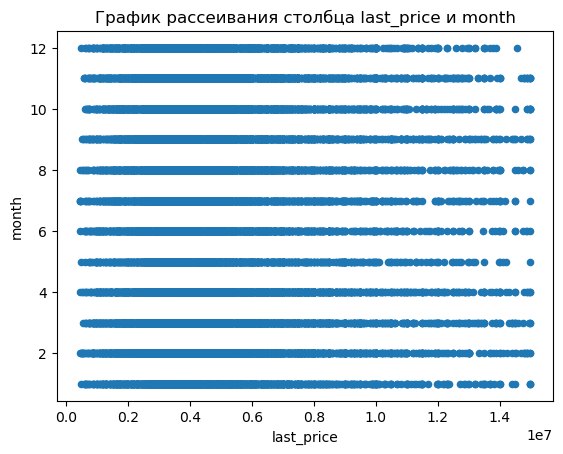

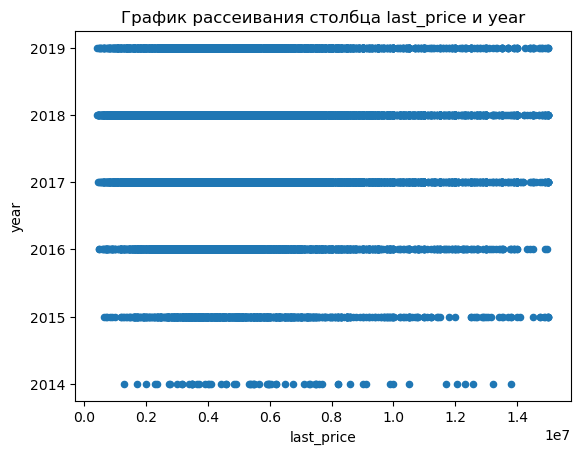

In [131]:
name_columns = ['total_area','living_area','kitchen_area','rooms','floor_type','weekday','month','year']
for column in name_columns:
    data.plot(x='last_price',y=column,kind='scatter')
    plt.title(f'График рассеивания столбца last_price и {column}')
plt.show()

In [132]:
data[['last_price','total_area','living_area','kitchen_area','rooms']].corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.718181,0.581405,0.483093,0.447042
total_area,0.718181,1.000000,0.906933,0.430229,0.804129
living_area,0.581405,0.906933,1.000000,0.176016,0.899134
kitchen_area,0.483093,0.430229,0.176016,1.000000,0.038919
rooms,0.447042,0.804129,0.899134,0.038919,1.000000


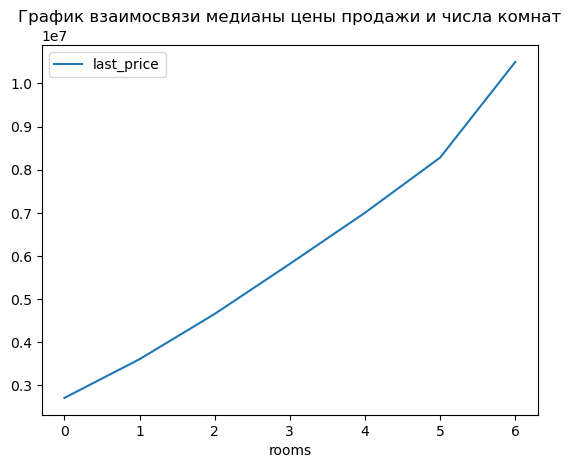

In [133]:
rooms_dependence= data.pivot_table(index='rooms',values='last_price',aggfunc='median')
rooms_dependence
rooms_dependence.plot()
plt.title('График взаимосвязи медианы цены продажи и числа комнат')
plt.show()

In [134]:
floors_type_dependence = data.pivot_table(index='floor_type',values='last_price',aggfunc='median')
floors_type_dependence

,last_price
floor_type,
другой,4600000.0
первый,3800000.0
последний,4000000.0


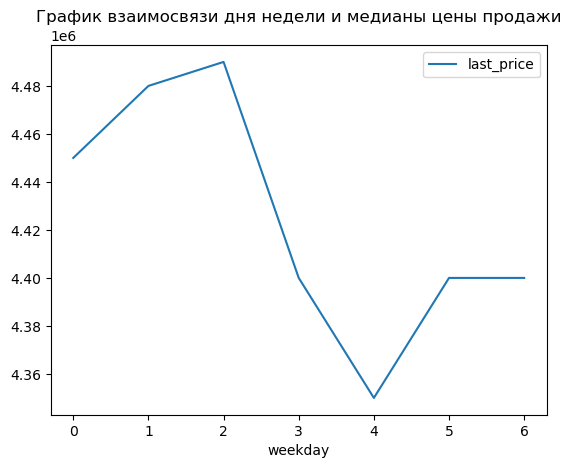

In [135]:
weekday_dependence = data.pivot_table(index='weekday',values='last_price',aggfunc='median')
weekday_dependence.plot()
plt.title('График взаимосвязи дня недели и медианы цены продажи')
plt.show()

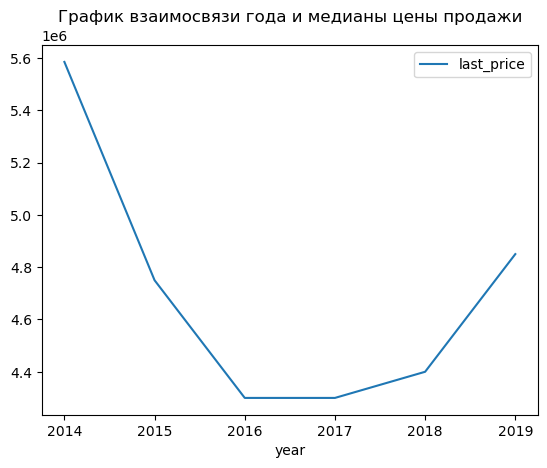

In [136]:
year_dependence = data.pivot_table(index='year',values='last_price',aggfunc='median')
year_dependence.plot()
plt.title('График взаимосвязи года и медианы цены продажи')
plt.show()

**Вывод по определению факторов влияния:**
Построив диаграммы рассеивания и матрицу корреляции основных параметров, можем сделать вывод, что **наибольшее влияния вносит общая площадь(total_area)**. Также, **некоторую корелляцию имеют столбцы *living_area, kitchen_area и rooms***. Что не лишено смысла, ведь эти показатели связаны логически со столбцом total_area. Тип этажа(**floor_type**) также имеет свой вес. Квартиры продающиеся не на 1м и последнем этаже стоят, как правило, дороже. А вот **дата влияния не оказала** абсолютно никакого.

Выбирая столбцы, которые влияют на стоимость недвижимости, можно оставить следующие:
- total_area
- living_area
- rooms
- floor_type
- kitchen_area

При этом стоит отметить, что total_area и living_area имеют высокую корелляцию меж собой.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [139]:
count_ads = data.pivot_table(index ='unique_locality_name', values='price_OneMS', aggfunc=['count','mean'])
count_ads.columns = ['count','mean']
count_ads['mean'] = count_ads['mean'].round(2)
top_count_ads = count_ads.sort_values(by='count',ascending=False).iloc[:10]

In [140]:
top_count_ads

,count,mean
unique_locality_name,,
Санкт-Петербург,13560,106901.34
Мурино,581,86241.96
Кудрово,451,95658.04
Шушары,433,78639.65
Всеволожск,385,67032.29
Пушкин,326,100957.72
Парголово,323,90223.86
Колпино,316,75350.13
Гатчина,301,68803.42


In [141]:
top_count_ads.sort_values(by='mean',ascending=False).iloc[[0,-1]]

,count,mean
unique_locality_name,,
Санкт-Петербург,13560,106901.34
Выборг,224,58119.68


**Результаты отбора топ 10 населённых пунктов по числу объявлений:**
Вполне логично, что самым популярным населённым пунктном стал Санкт-Петербург. Помимо этого он обладает самой высокой стоимостью квадратного метра недвижимости. И разница стоимости весьма велика. Минимальный порог среди популярных населённых пунктов почти в 2 раза ниже.

#### Определить стоимость квартир в Санкт-Петербурге на разном удалении от центра города

In [144]:
impact_distance_on_cost_SP = data.pivot_table(index='cityCenters_nearest_km',values='last_price')
impact_distance_on_cost_SP.head()

,last_price
cityCenters_nearest_km,
0.0,9.029844e+06
1.0,8.721748e+06
2.0,8.082593e+06
3.0,7.617833e+06
4.0,8.229190e+06


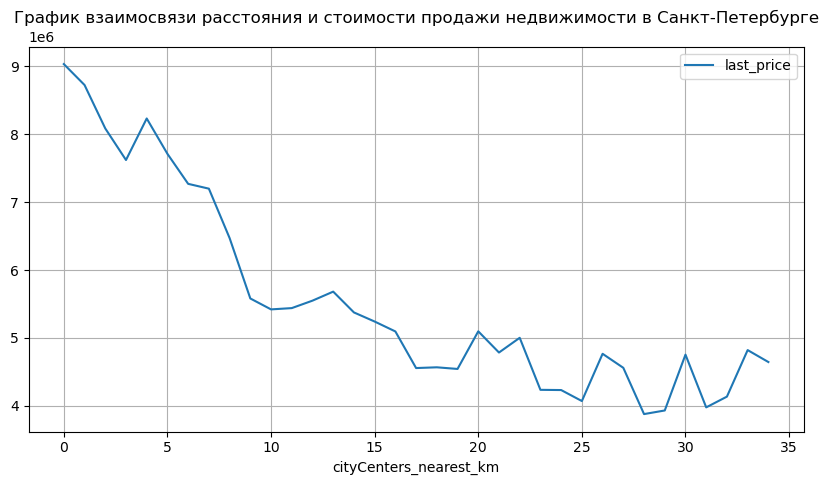

In [145]:
impact_distance_on_cost_SP.plot(grid=True,figsize=(10,5))
plt.title('График взаимосвязи расстояния и стоимости продажи недвижимости в Санкт-Петербурге')
plt.show()

In [146]:
# Средняя стоимость жилья на расстояния 3х километров от центра Санкт-Петербурга
impact_distance_on_cost_SP.iloc[:3].mean()

last_price    8.611395e+06
dtype: float64

In [147]:
# Средняя стоимость жилья максимально удалённого от центра Санкт-Петербурга
impact_distance_on_cost_SP.iloc[-3:].mean()

last_price    4.533142e+06
dtype: float64

**Вывод пункта 4.5:**
Исследовав получившийся график, становится очевидно, что расстояние до центра имеет важное значение в ценообразовании недвижимости. Чем ближе расположена квартира к центру города - тем выше её стоимость. В конечном итоге эта разница может принимать двухкратных значения.


### Напишите общий вывод

Было проведено большое исследования стоимости недвижимости в окрестностях Санкт-Петербурга. *Целью исследования* было определения рыночной стоимость квартир. Для этого был проведён исследовательский анализ данных и были установлены параметры влияющие на стоимость объектов жилья. 

На этапе знакомства с данными и их преобработки были изучены пропуски данных, которых в ряде столбцов оказлось весьма много. Часть пропусков, полученных в результате человеческой ошибки удалось устранить, однако данные, пропущенные в результате технического сбоя никуда не делись. Также ряд столбцов был преобразован в сооветствующиий им тип данных. Некоторые трудности доставил процесс избавления от неявных дубликатов ввиду свободной формы заполнения населённого пункта. На основе этого можно сразу сделать общую рекомендацию: **запретить свободных ввод названия населённого пункта**, оставив выбор из выпадающего списка по соответствиям ввода.

Следующим этапом стало внесение дополнительных столбцов с целью их использования в дальнейшем процессе исследования. Ранее преобразованный тип даты сильно поспособствовал в этом. 

Переходя непосредственно к исследования данных, первым делом были изучены основные параметры таблицы на предмет наличия редких значений и аномалий. По результатам изучения были отброшены порядка 10% данных, что могли оказать негативное влияние на дальнейшее исследование.

Заключительным этапом стало исследование влияния основных параметров на итоговую стоимость квартиры. Наибольший уровень корреляции столбец отвечающий за общую площадь недвижимости. 

Подводя итог проделанной работы хочется отметить параметры, которые в обязательно порядке нужно учитывать при прогнозировании стоимости недвижимости:
- Общая площадь (total_area)
- Жилая зона (living_area)
- Число комнат (rooms)
- Площадь кухни (kitchen_area)
- Тип этажа (floor_type)
- Расстояние до центра города (cityCenters_nearest_km).

**Спасибо за уделённое время!**



**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.